In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': '90%',
        'height': '90%',
        'scroll': True,
})

{'width': '90%', 'height': '90%', 'scroll': True}

# Faster Development

Code execution speed isn't the only place were modelers lose time. We can also speed up our development cycle by using symbolic math libraries like `sympy`. These offer several advantages:

1. Directly program a model as mathematical expressions
2. Use solvers and symbolic differentiation to automate tedious algebra and reduce mistakes
3. Compile mathematical expressions directly to python functions.

# Using Sympy

Consider the well-known IS-TR model of the macroeconomy:

$$\begin{align}
Y &= C + I + G \\
C &= c_0 + c_1 (1 - \tau) Y \\
I &= i_0 + i_1 Y + i_2 i \\
G &= \bar{G} \\
\end{align}$$

This is a fully linear system of equations, and can be trivially solved for a reduced form in $Y$. Instead of doing it by hand, we can use `sympy` to automate the calculations:

In [8]:
import sympy as sp
Y, i, C, I, G = sp.symbols('Y i C I G')
c0, c1, i0, i1, i2, G_bar, tau = sp.symbols('c_0 c_1 i_0 i_1 i_2 \\bar{G} \\tau')

eq1 = sp.Eq(Y, C + I + G)
eq2 = sp.Eq(C, c0 + c1 * (1 - tau) * Y)
eq3 = sp.Eq(I, i0 + i1 * Y + i2 * i)
eq4 = sp.Eq(G, G_bar)

system = [eq1, eq2, eq3, eq4]

In [9]:
for eq in system:
    display(eq)

Eq(Y, C + G + I)

Eq(C, Y*c_1*(1 - \tau) + c_0)

Eq(I, Y*i_1 + i*i_2 + i_0)

Eq(G, \bar{G})

Once we have the algebraic system, we can ask sympy to solve it for us. In this case, because the system is all linear, it will be very effective. We pass the system of equations, along with a list of variables to be solved for. In this case, we solve for $Y$, $C$, $I$, $G$.

In [15]:
# sp.solve returns a dictionary
solutions = sp.solve(system, [Y, C, I, G])

for var, eq in solutions.items():
    display(sp.Eq(var, eq))

Eq(C, (-\bar{G}*\tau*c_1 + \bar{G}*c_1 - \tau*c_1*i*i_2 - \tau*c_1*i_0 - c_0*i_1 + c_0 + c_1*i*i_2 + c_1*i_0)/(\tau*c_1 - c_1 - i_1 + 1))

Eq(G, \bar{G})

Eq(I, (\bar{G}*i_1 + \tau*c_1*i*i_2 + \tau*c_1*i_0 + c_0*i_1 - c_1*i*i_2 - c_1*i_0 + i*i_2 + i_0)/(\tau*c_1 - c_1 - i_1 + 1))

Eq(Y, (\bar{G} + c_0 + i*i_2 + i_0)/(\tau*c_1 - c_1 - i_1 + 1))

Solutions produced by sympy are not always the most beautiful. You can ask for them to be cleaned up by using the `.collect` method

In [23]:
Y_solved = solutions[Y]
Y_solved.collect(c1)

(\bar{G} + c_0 + i*i_2 + i_0)/(c_1*(\tau - 1) - i_1 + 1)

The solution for $Y$ is the IS curve. Together with a Taylor Rule, we can solve for an IS-TR equilibrium. A taylor rule is given by:

$$i = \bar i + \alpha (\pi - \bar \pi) + \beta \left ( \frac{Y - \bar Y}{\bar Y} \right )$$

In [39]:
alpha, beta, pi_bar, Y_bar, i_bar = sp.symbols('alpha beta \\bar{\pi} \\bar{Y} \\bar{i}')
pi = sp.Symbol('pi')

tr_curve = sp.Eq(i, i_bar + alpha * (pi - pi_bar) + beta * ((Y - Y_bar) / Y_bar))
is_curve = sp.Eq(Y, Y_solved)

display(tr_curve)
display(is_curve)

Eq(i, \bar{i} + alpha*(-\bar{\pi} + pi) + beta*(Y - \bar{Y})/\bar{Y})

Eq(Y, (\bar{G} + c_0 + i*i_2 + i_0)/(\tau*c_1 - c_1 - i_1 + 1))

The IS-TR equilibrium can once again be solved for by using `sp.solve`. Again, these equations are not complicated to solve by hand, but they are quite tedious and error prone. Using a computer algebra system can save significant work!

In [40]:
is_tr_solutions = sp.solve([is_curve, tr_curve], [Y, i])
for var, eq in is_tr_solutions.items():
    display(sp.Eq(var, eq.collect(Y_bar)))

Eq(Y, \bar{Y}*(\bar{G} - \bar{\pi}*alpha*i_2 + \bar{i}*i_2 + alpha*i_2*pi - beta*i_2 + c_0 + i_0)/(\bar{Y}*(\tau*c_1 - c_1 - i_1 + 1) - beta*i_2))

Eq(i, (\bar{G}*beta + \bar{Y}*(-\bar{\pi}*\tau*alpha*c_1 + \bar{\pi}*alpha*c_1 + \bar{\pi}*alpha*i_1 - \bar{\pi}*alpha + \bar{i}*\tau*c_1 - \bar{i}*c_1 - \bar{i}*i_1 + \bar{i} + \tau*alpha*c_1*pi - \tau*beta*c_1 - alpha*c_1*pi - alpha*i_1*pi + alpha*pi + beta*c_1 + beta*i_1 - beta) + beta*c_0 + beta*i_0)/(\bar{Y}*(\tau*c_1 - c_1 - i_1 + 1) - beta*i_2))

These expressions are quite horrible -- we can clean them up significantly with `.collect`, or leave them be

In [44]:
is_tr_solutions[Y].collect(Y_bar).collect(c1).collect(i2).collect(alpha)

\bar{Y}*(\bar{G} + c_0 + i_0 + i_2*(\bar{i} + alpha*(-\bar{\pi} + pi) - beta))/(\bar{Y}*(c_1*(\tau - 1) - i_1 + 1) - beta*i_2)

## Translating to Python Code with `sp.lambdify`

Having symbolic solutions is nice, but frequently we only solve models in order to then turn around and run simulations. To do this, we need to convert the model to python code. This might involve manually creating functions. Sympy can also help with this, using the `sp.lambdify` function.

In [54]:
f_Y_solution = sp.lambdify([c0, c1, i0, i1, i2, i_bar, Y_bar, G_bar, pi_bar, alpha, beta, pi, tau], 
                           is_tr_solutions[Y])
f_i_solution = sp.lambdify([c0, c1, i0, i1, i2, i_bar, Y_bar, G_bar, pi_bar, alpha, beta, pi, tau], 
                           is_tr_solutions[i])

In [129]:
param_dict = {
    'c_0': 1,        # base consumption
    'c_1': 0.5,      # mpc
    'i_0': 1,        # base investmnet
    'i_1': 0.25,     # mpi -- "animal spirits"
    'i_2': -0.12,    # interest rate sensitivity
    'i_bar': 0.05,  # natural interest rate
    'Y_bar': 1,     # natural output
    'G_bar': 1,     # exogenous government spending
    'pi_bar':0.03,  # inflation target
    'alpha': 1.5,   # central bank inflation reaction strength
    'beta': 0.025,  # central bank output gap reaction strength
    'pi': 0.08,     # inflation
    'tau': 0.12     # tax rate
}

print(f'Equlibrium Y: {f_Y_solution(*param_dict.values()):0.2f}')
print(f'Equlibrium i: {f_i_solution(*param_dict.values()):0.2f}')

Equlibrium Y: 9.55
Equlibrium i: 0.34


## Plotting

We can also lambdify the curve functions to make a nice plot. To do this, we have to get both equations into the form i = f(Y). The TR curve already is, but we can use `sp.solve` to put the IS curve into the correct form.

In [130]:
is_curve_inv = sp.solve(is_curve, i)[0]
is_curve_inv

(Y*\tau*c_1 - Y*c_1 - Y*i_1 + Y - \bar{G} - c_0 - i_0)/i_2

In [131]:
is_inputs = ['c_0', 'c_1', 'i_0', 'i_1', 'i_2', 'G_bar', 'tau']
tr_inputs = ['i_bar', 'pi_bar', 'Y_bar', 'alpha', 'beta', 'pi']

f_is = sp.lambdify([Y, c0, c1, i0, i1, i2, G_bar, tau], is_curve_inv)
f_tr = sp.lambdify([Y, i_bar, pi_bar, Y_bar, alpha, beta, pi], tr_curve.rhs)

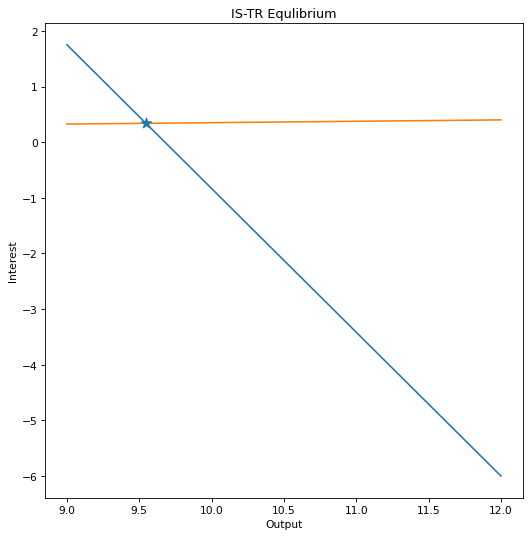

In [132]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8), dpi=77)

Y_grid = np.linspace(9, 12, 100)
ax.plot(Y_grid, f_is(Y_grid, *[param_dict.get(x) for x in is_inputs]))
ax.plot(Y_grid, f_tr(Y_grid, *[param_dict.get(x) for x in tr_inputs]))
ax.scatter(f_Y_solution(*param_dict.values()), f_i_solution(*param_dict.values()), 
           marker='*', s=100, zorder=10)
ax.set(title='IS-TR Equlibrium', xlabel='Output', ylabel='Interest')
plt.show()

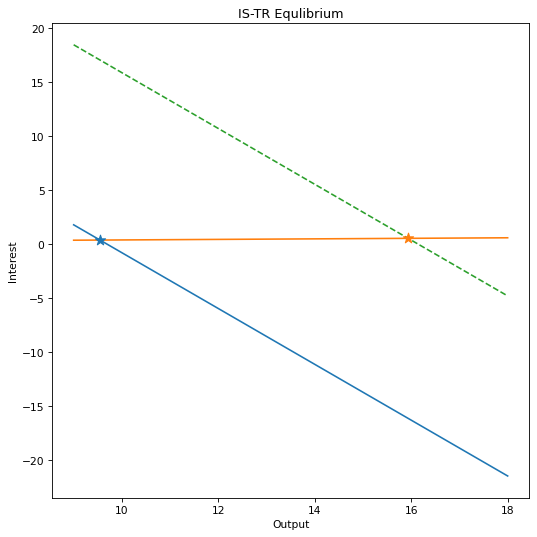

In [133]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8), dpi=77)

spending_shock = param_dict.copy()
spending_shock['G_bar'] += 2

Y_grid = np.linspace(9, 18, 100)

ax.plot(Y_grid, f_is(Y_grid, *[param_dict.get(x) for x in is_inputs]))
ax.plot(Y_grid, f_tr(Y_grid, *[param_dict.get(x) for x in tr_inputs]))

ax.scatter(f_Y_solution(*param_dict.values()), f_i_solution(*param_dict.values()), 
           marker='*', s=100, zorder=10)

ax.plot(Y_grid, f_is(Y_grid, *[spending_shock.get(x) for x in is_inputs]), ls='--')

ax.scatter(f_Y_solution(*spending_shock.values()), f_i_solution(*spending_shock.values()), 
           marker='*', s=100, zorder=10)

ax.set(title='IS-TR Equlibrium', xlabel='Output', ylabel='Interest')
plt.show()

# Comparative Statics with `.diff`

Finally, we can compute symbolic derivatives using `.diff`. In the IS-TR example, this is useful for doing comparative statics. We can, for instance, compute the effect of changes in the central bank's inflation target, $\bar{\pi}$, on equilibrium output.

We can be sure that this is positive (as expected) because $\frac{1}{1 - (1 - \tau)c_1 - i_1}$ is the fiscal multiplier, and must be strictly positive. Notice that sympy puts that minus sign out front -- you need to mentally factor it back in.

In [138]:
is_tr_solutions[Y].diff(pi_bar).collect(Y_bar).collect(c1)

-\bar{Y}*alpha*i_2/(\bar{Y}*(c_1*(\tau - 1) - i_1 + 1) - beta*i_2)

We will see in the last section that symbolic differentiation is just the tip of the iceberg when it comes to what can be done with automatic differentiation in modern Python packages.